# Predict Taxi Trip Duration

In [1]:
# Necessary import
import pickle
import mlflow # for experiment tracking
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.svm import LinearSVR

# hyperopt uses bayesian methods to find the best set of hyperparameters
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
# fmin: to minimize the objective function - rmse
# tpe: the algorithm to control the optimization logic
# hp: methods to define hyperparameters ranges
# STATUS_OK: signal to indicate that the objective function has run successfully during a run
# Trials: to keep track of information for each run

# Python version
!python -V

Python 3.9.18


In [2]:
# Set the tracking uri
mlflow.set_tracking_uri("sqlite:///mlflow.db") # where metadata are stored
# Set the experiment (creating it if doesn't exist)
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/cm-mboulou-mac/Dvt/MLOps-Zoomcamp-2025/02_experiment-tracking/notebooks/mlruns/1', creation_time=1748104706317, experiment_id='1', last_update_time=1748104706317, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [3]:
# Read the data set
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

# First rows
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
# Feature Engineering for creating target variable
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
# Convert duration from seconds to minutes
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# Filtering for trips lasting from 1 min to 1 hour
df = df[(df.duration >= 1) & (df.duration <= 60)]

# Subset features
categorical = ['PULocationID', 'DOLocationID'] # categorically
numerical = ['trip_distance'] # numerically

# Type conversion for location identifyers - from numbers to string
df[categorical] = df[categorical].astype(str)

In [5]:
# Build the train dictionaries
train_dicts = df[categorical + numerical].to_dict(orient = 'records')

# Initialize a vectorizer for encoding
dv = DictVectorizer()
# Encoder training
X_train = dv.fit_transform(train_dicts)

# Set the target variable
target = 'duration'
# Target vector
y_train = df[target].values

In [6]:
# Initialize a linear regression model
lr = LinearRegression()
# Model training
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_train)

# RMSE metric
root_mean_squared_error(y_train, y_pred)

9.827368941909368

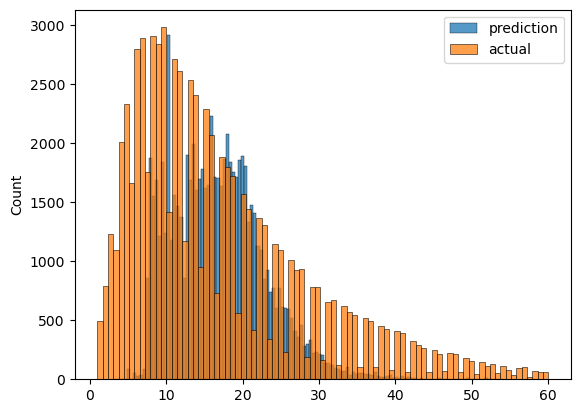

In [7]:
# Visualize training distributions
sns.histplot(y_pred, label = 'prediction') # for predictions
sns.histplot(y_train, label = 'actual') # for real values
# sns.distplot() is deprecated - we would have used it instead

# Add a legend
plt.legend();

In [8]:
# Function for wrangling the data
def read_dataframe(filename):
    # If the data is a csv file
    if filename.endswith('.csv'):
        # Read csv
        df = pd.read_csv(filename)
        # Convert to datetime
        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    # else if it is a parquet file
    elif filename.endswith('.parquet'):
        # read parquet
        df = pd.read_parquet(filename)
    # Not considered file type
    else:
        print("File not supported") # error message

    # Feature Engineering
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime # target var
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60) # for minutes
    # Filtering durations
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    # Categorical features selection
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str) # convert integers to string

    # return the dataframe
    return df

In [9]:
# Read the train and validation sets
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet') # train
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet') # validation

# Data size
len(df_train), len(df_val)

(73908, 61921)

In [10]:
# Feature Engineering to combine taxi trips origine and destination
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

# Set feature variables
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID
numerical = ['trip_distance']

In [11]:
# Initialize one-hot encoder
dv = DictVectorizer()

# Train data dictionaries
train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
# Encoder training
X_train = dv.fit_transform(train_dicts)

# Validation data dictionaries
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
# Validation data encoding
X_val = dv.transform(val_dicts)

In [12]:
# Set target variables
target = 'duration'
# Train and validation target vectors
y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
# Initialize linear regression model
lr = LinearRegression()
# Model training
lr.fit(X_train, y_train)

# Make predictions
y_pred = lr.predict(X_val)

# RMSE metric
root_mean_squared_error(y_val, y_pred)

7.758715203628836

In [14]:
# Initialize a lasso model (linear regressor with penalization)
lasso_reg = Lasso(0.01)
# Lasso training
lasso_reg.fit(X_train, y_train)

# Get predictions
y_pred = lasso_reg.predict(X_val)

# RMSE metric
root_mean_squared_error(y_val, y_pred)

11.167275941179728

In [15]:
# Initialize a ridge model (linear regressor with penalization)
ridge_reg = Ridge(0.01)
# Lasso training
ridge_reg.fit(X_train, y_train)

# Get predictions
y_pred = ridge_reg.predict(X_val)

# RMSE metric
root_mean_squared_error(y_val, y_pred)

7.509209748700909

In [16]:
# Save the best model in a binary file
with open('models/ridge_reg.bin', 'wb') as f_out:
    pickle.dump((dv, ridge_reg), f_out)

## With MLFlow

In [17]:
# Define a new run to add tracking
with mlflow.start_run():
    # Set a tag to know who worked on the project
    mlflow.set_tag("developer", "Maximilien")
    
    # Log info about the data
    mlflow.log_param("train_data-path", "./data/green_tripdata_2021-01.parquet") # train
    mlflow.log_param("val_data-path", "./data/green_tripdata_2021-02.parquet") # validation

    # Model parameter
    alpha = 0.1 # we can change alpha from 0.01 to 0.1 in another runb
    # Log the parameter
    mlflow.log_param("alpha", alpha)
    
    # Initialize linear regression model
    lr = Ridge(alpha)
    # Model training
    lr.fit(X_train, y_train)
    
    # Make predictions
    y_pred = lr.predict(X_val)
    
    # RMSE metric
    rmse = root_mean_squared_error(y_val, y_pred)
    # Log the metric
    mlflow.log_metric("rmse", rmse)
    

## XG-Boost Model

In [18]:
# Prepare the data with XG-Boost special format
train = xgb.DMatrix(X_train, label = y_train) # train
valid = xgb.DMatrix(X_val, label = y_val) # val

In [19]:
# Function to get XG-Boost RMSE
def objective(params):
    # Start a new run
    with mlflow.start_run():
        # Tag to indicate the model
        mlflow.set_tag("model", "xgboost")
        # Log the model parameters
        mlflow.log_params(params)
        # Model training
        booster = xgb.train(
            params = params,
            dtrain = train,
            num_boost_round = 1000, # number of iterations
            evals = [(valid, 'validation')],
            early_stopping_rounds = 50
        )
        # Make predictions
        y_pred = booster.predict(valid)
        # Computer the RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Log the model metric
        mlflow.log_metric("rmse", rmse)

    # Return metric and status to indictae completion
    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
# Hyper-parameters search space (ranges)
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # [exp(-3), exp(0)] -> [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear', # reg:squarederror
    'seed': 42
}
# Note that trying first higher values of learning rates and then lower makes sense with XG-Boost

# Model hyperparameters tuning
best_result = fmin(
    fn = objective, # objective function
    space = search_space,
    algo = tpe.suggest, # algo to run the optimization
    max_evals = 50, # number of iterations
    trials = Trials() # to store all runs information
)

  0%|                              | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:06:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75065                                              
[1]	validation-rmse:9.63855                                               
[2]	validation-rmse:8.80446                                               
[3]	validation-rmse:8.18882                                               
[4]	validation-rmse:7.74054                                               
[5]	validation-rmse:7.41494                                               
[6]	validation-rmse:7.17766                                               
[7]	validation-rmse:7.00828                                               
[8]	validation-rmse:6.88620                                               
[9]	validation-rmse:6.79690                                               
[10]	validation-rmse:6.73023                                              
[11]	validation-rmse:6.68133                                              
[12]	validation-rmse:6.64250                                              
[13]	validation-rmse:6.61

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79158                                              
[1]	validation-rmse:11.39810                                              
[2]	validation-rmse:11.03160                                              
[3]	validation-rmse:10.68981                                              
[4]	validation-rmse:10.37204                                              
[5]	validation-rmse:10.07590                                              
[6]	validation-rmse:9.80090                                               
[7]	validation-rmse:9.54709                                               
[8]	validation-rmse:9.30997                                               
[9]	validation-rmse:9.09177                                               
[10]	validation-rmse:8.88939                                              
[11]	validation-rmse:8.70221                                              
[12]	validation-rmse:8.52926                                              
[13]	validation-rmse:8.36

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.09535                                               
[2]	validation-rmse:7.38010                                               
[3]	validation-rmse:7.02866                                               
[4]	validation-rmse:6.85297                                               
[5]	validation-rmse:6.75308                                               
[6]	validation-rmse:6.70233                                               
[7]	validation-rmse:6.67314                                               
[8]	validation-rmse:6.65448                                               
[9]	validation-rmse:6.64035                                               
[10]	validation-rmse:6.63540                                              
[11]	validation-rmse:6.62894                                              
[12]	validation-rmse:6.62626                                              
[13]	validation-rmse:6.62266                                              
[14]	validation-rmse:6.61

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.35156                                               
[2]	validation-rmse:6.93489                                               
[3]	validation-rmse:6.79082                                               
[4]	validation-rmse:6.73303                                               
[5]	validation-rmse:6.70859                                               
[6]	validation-rmse:6.69893                                               
[7]	validation-rmse:6.68916                                               
[8]	validation-rmse:6.68296                                               
[9]	validation-rmse:6.67602                                               
[10]	validation-rmse:6.67053                                              
[11]	validation-rmse:6.66526                                              
[12]	validation-rmse:6.66281                                              
[13]	validation-rmse:6.66077                                              
[14]	validation-rmse:6.65

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.54214                                               
[4]	validation-rmse:7.21547                                               
[5]	validation-rmse:7.01479                                               
[6]	validation-rmse:6.88877                                               
[7]	validation-rmse:6.80758                                               
[8]	validation-rmse:6.75154                                               
[9]	validation-rmse:6.71663                                               
[10]	validation-rmse:6.69391                                              
[11]	validation-rmse:6.67514                                              
[12]	validation-rmse:6.66229                                              
[13]	validation-rmse:6.65371                                              
[14]	validation-rmse:6.64706                                              
[15]	validation-rmse:6.64185                                              
[16]	validation-rmse:6.63

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.74551                                              
[1]	validation-rmse:11.31255                                              
[2]	validation-rmse:10.91203                                              
[3]	validation-rmse:10.54208                                              
[4]	validation-rmse:10.20057                                              
[5]	validation-rmse:9.88594                                               
[6]	validation-rmse:9.59663                                               
[7]	validation-rmse:9.33057                                               
[8]	validation-rmse:9.08619                                               
[9]	validation-rmse:8.86193                                               
[10]	validation-rmse:8.65649                                              
[11]	validation-rmse:8.46869                                              
[12]	validation-rmse:8.29708                                              
[13]	validation-rmse:8.14

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:11:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.32608                                              
[1]	validation-rmse:10.56494                                              
[2]	validation-rmse:9.91499                                               
[3]	validation-rmse:9.36379                                               
[4]	validation-rmse:8.89599                                               
[5]	validation-rmse:8.50260                                               
[6]	validation-rmse:8.17323                                               
[7]	validation-rmse:7.89843                                               
[8]	validation-rmse:7.66926                                               
[9]	validation-rmse:7.47952                                               
[10]	validation-rmse:7.32250                                              
[11]	validation-rmse:7.19100                                              
[12]	validation-rmse:7.08241                                              
[13]	validation-rmse:6.99

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:11:59] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.91038                                               
[1]	validation-rmse:6.83532                                               
[2]	validation-rmse:6.57647                                               
[3]	validation-rmse:6.49760                                               
[4]	validation-rmse:6.46264                                               
[5]	validation-rmse:6.44761                                               
[6]	validation-rmse:6.43832                                               
[7]	validation-rmse:6.43272                                               
[8]	validation-rmse:6.42673                                               
[9]	validation-rmse:6.42036                                               
[10]	validation-rmse:6.41364                                              
[11]	validation-rmse:6.40866                                              
[12]	validation-rmse:6.40538                                              
[13]	validation-rmse:6.39

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:12:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.29728                                              
[2]	validation-rmse:10.89164                                              
[3]	validation-rmse:10.51794                                              
[4]	validation-rmse:10.17379                                              
[5]	validation-rmse:9.85740                                               
[6]	validation-rmse:9.56727                                               
[7]	validation-rmse:9.30141                                               
[8]	validation-rmse:9.05771                                               
[9]	validation-rmse:8.83508                                               
[10]	validation-rmse:8.63240                                              
[11]	validation-rmse:8.44679                                              
[12]	validation-rmse:8.27774                                              
[13]	validation-rmse:8.12431                                              
[14]	validation-rmse:7.98

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:13:40] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.34259                                               
[2]	validation-rmse:7.58500                                               
[3]	validation-rmse:7.18316                                               
[4]	validation-rmse:6.97283                                               
[5]	validation-rmse:6.85501                                               
[6]	validation-rmse:6.78480                                               
[7]	validation-rmse:6.74701                                               
[8]	validation-rmse:6.72201                                               
[9]	validation-rmse:6.70593                                               
[10]	validation-rmse:6.69501                                              
[11]	validation-rmse:6.68333                                              
[12]	validation-rmse:6.67642                                              
[13]	validation-rmse:6.67112                                              
[14]	validation-rmse:6.66

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:15] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.81812                                              
[2]	validation-rmse:10.24660                                              
[3]	validation-rmse:9.74724                                               
[4]	validation-rmse:9.31302                                               
[5]	validation-rmse:8.93726                                               
[6]	validation-rmse:8.61269                                               
[7]	validation-rmse:8.33297                                               
[8]	validation-rmse:8.09303                                               
[9]	validation-rmse:7.88559                                               
[10]	validation-rmse:7.70783                                              
[11]	validation-rmse:7.55635                                              
[12]	validation-rmse:7.42700                                              
[13]	validation-rmse:7.31644                                              
[14]	validation-rmse:7.22

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:14:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:9.88092                                               
[6]	validation-rmse:9.59626                                               
[7]	validation-rmse:9.33513                                               
[8]	validation-rmse:9.09658                                               
[9]	validation-rmse:8.87978                                               
[10]	validation-rmse:8.68122                                              
[11]	validation-rmse:8.50120                                              
[12]	validation-rmse:8.33771                                              
[13]	validation-rmse:8.18857                                              
[14]	validation-rmse:8.05414                                              
[15]	validation-rmse:7.93136                                              
[16]	validation-rmse:7.82053                                              
[17]	validation-rmse:7.72003                                              
[18]	validation-rmse:7.62

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.60161                                               
[1]	validation-rmse:6.75797                                               
[2]	validation-rmse:6.58858                                               
[3]	validation-rmse:6.53777                                               
[4]	validation-rmse:6.51286                                               
[5]	validation-rmse:6.49255                                               
[6]	validation-rmse:6.48555                                               
[7]	validation-rmse:6.47724                                               
[8]	validation-rmse:6.47137                                               
[9]	validation-rmse:6.46737                                               
[10]	validation-rmse:6.46594                                              
[11]	validation-rmse:6.46223                                              
[12]	validation-rmse:6.45983                                              
[13]	validation-rmse:6.45

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:15:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.75723                                               
[2]	validation-rmse:8.94453                                               
[3]	validation-rmse:8.33517                                               
[4]	validation-rmse:7.88323                                               
[5]	validation-rmse:7.55021                                               
[6]	validation-rmse:7.30341                                               
[7]	validation-rmse:7.12266                                               
[8]	validation-rmse:6.99115                                               
[9]	validation-rmse:6.89487                                               
[10]	validation-rmse:6.82113                                              
[11]	validation-rmse:6.76515                                              
[12]	validation-rmse:6.72336                                              
[13]	validation-rmse:6.69185                                              
[14]	validation-rmse:6.66

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:16:02] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.67155                                               
[3]	validation-rmse:6.66018                                               
[4]	validation-rmse:6.65110                                               
[5]	validation-rmse:6.64855                                               
[6]	validation-rmse:6.64172                                               
[7]	validation-rmse:6.63310                                               
[8]	validation-rmse:6.62794                                               
[9]	validation-rmse:6.62036                                               
[10]	validation-rmse:6.61515                                              
[11]	validation-rmse:6.61055                                              
[12]	validation-rmse:6.60466                                              
[13]	validation-rmse:6.60154                                              
[14]	validation-rmse:6.59959                                              
[15]	validation-rmse:6.59

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:16:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.76579                                               
[4]	validation-rmse:7.39973                                               
[5]	validation-rmse:7.16210                                               
[6]	validation-rmse:7.00632                                               
[7]	validation-rmse:6.90237                                               
[8]	validation-rmse:6.83543                                               
[9]	validation-rmse:6.78767                                               
[10]	validation-rmse:6.75319                                              
[11]	validation-rmse:6.72831                                              
[12]	validation-rmse:6.71124                                              
[13]	validation-rmse:6.69715                                              
[14]	validation-rmse:6.68987                                              
[15]	validation-rmse:6.68278                                              
[16]	validation-rmse:6.67

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:16:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97351                                               
[1]	validation-rmse:7.59549                                               
[2]	validation-rmse:7.04974                                               
[3]	validation-rmse:6.83036                                               
[4]	validation-rmse:6.73051                                               
[5]	validation-rmse:6.67936                                               
[6]	validation-rmse:6.65634                                               
[7]	validation-rmse:6.63790                                               
[8]	validation-rmse:6.62823                                               
[9]	validation-rmse:6.61698                                               
[10]	validation-rmse:6.61118                                              
[11]	validation-rmse:6.60818                                              
[12]	validation-rmse:6.60539                                              
[13]	validation-rmse:6.60

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:17:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96412                                               
[1]	validation-rmse:6.90713                                               
[2]	validation-rmse:6.64748                                               
[3]	validation-rmse:6.56127                                               
[4]	validation-rmse:6.52957                                               
[5]	validation-rmse:6.51413                                               
[6]	validation-rmse:6.51215                                               
[7]	validation-rmse:6.50342                                               
[8]	validation-rmse:6.49668                                               
[9]	validation-rmse:6.49048                                               
[10]	validation-rmse:6.48850                                              
[11]	validation-rmse:6.48220                                              
[12]	validation-rmse:6.47551                                              
[13]	validation-rmse:6.47

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:17:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:7.73290                                               
[4]	validation-rmse:7.37292                                               
[5]	validation-rmse:7.14087                                               
[6]	validation-rmse:6.99031                                               
[7]	validation-rmse:6.89090                                               
[8]	validation-rmse:6.82758                                               
[9]	validation-rmse:6.78098                                               
[10]	validation-rmse:6.74992                                              
[11]	validation-rmse:6.72500                                              
[12]	validation-rmse:6.70718                                              
[13]	validation-rmse:6.69640                                              
[14]	validation-rmse:6.68799                                              
[15]	validation-rmse:6.68063                                              
[16]	validation-rmse:6.67

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:17:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.07200                                              
[1]	validation-rmse:8.70909                                               
[2]	validation-rmse:7.87822                                               
[3]	validation-rmse:7.37824                                               
[4]	validation-rmse:7.05998                                               
[5]	validation-rmse:6.88423                                               
[6]	validation-rmse:6.77713                                               
[7]	validation-rmse:6.70732                                               
[8]	validation-rmse:6.65960                                               
[9]	validation-rmse:6.62688                                               
[10]	validation-rmse:6.60522                                              
[11]	validation-rmse:6.58998                                              
[12]	validation-rmse:6.57780                                              
[13]	validation-rmse:6.56

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:18:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.20872                                              
[1]	validation-rmse:10.37290                                              
[2]	validation-rmse:9.67721                                               
[3]	validation-rmse:9.10199                                               
[4]	validation-rmse:8.63207                                               
[5]	validation-rmse:8.24920                                               
[6]	validation-rmse:7.92910                                               
[7]	validation-rmse:7.66933                                               
[8]	validation-rmse:7.46653                                               
[9]	validation-rmse:7.30015                                               
[10]	validation-rmse:7.16693                                              
[11]	validation-rmse:7.05558                                              
[12]	validation-rmse:6.96983                                              
[13]	validation-rmse:6.89

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:18:55] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53942                                              
[1]	validation-rmse:10.93905                                              
[2]	validation-rmse:10.40460                                              
[3]	validation-rmse:9.93162                                               
[4]	validation-rmse:9.51219                                               
[5]	validation-rmse:9.14321                                               
[6]	validation-rmse:8.81748                                               
[7]	validation-rmse:8.53438                                               
[8]	validation-rmse:8.28406                                               
[9]	validation-rmse:8.06500                                               
[10]	validation-rmse:7.87380                                              
[11]	validation-rmse:7.70892                                              
[12]	validation-rmse:7.56401                                              
[13]	validation-rmse:7.43

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:19:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53684                                              
[1]	validation-rmse:10.93394                                              
[2]	validation-rmse:10.39726                                              
[3]	validation-rmse:9.92378                                               
[4]	validation-rmse:9.50342                                               
[5]	validation-rmse:9.13497                                               
[6]	validation-rmse:8.80994                                               
[7]	validation-rmse:8.52567                                               
[8]	validation-rmse:8.27469                                               
[9]	validation-rmse:8.05810                                               
[10]	validation-rmse:7.86826                                              
[11]	validation-rmse:7.70350                                              
[12]	validation-rmse:7.55943                                              
[13]	validation-rmse:7.43

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:20:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.59198                                              
[1]	validation-rmse:11.03574                                              
[2]	validation-rmse:10.53450                                              
[3]	validation-rmse:10.08486                                              
[4]	validation-rmse:9.68479                                               
[5]	validation-rmse:9.32583                                               
[6]	validation-rmse:9.00830                                               
[7]	validation-rmse:8.72471                                               
[8]	validation-rmse:8.47701                                               
[9]	validation-rmse:8.25328                                               
[10]	validation-rmse:8.05992                                              
[11]	validation-rmse:7.88471                                              
[12]	validation-rmse:7.73480                                              
[13]	validation-rmse:7.59

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:21:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.15680                                              
[1]	validation-rmse:10.28367                                              
[2]	validation-rmse:9.56966                                               
[3]	validation-rmse:8.98683                                               
[4]	validation-rmse:8.51518                                               
[5]	validation-rmse:8.13432                                               
[6]	validation-rmse:7.83514                                               
[7]	validation-rmse:7.58933                                               
[8]	validation-rmse:7.39769                                               
[9]	validation-rmse:7.24869                                               
[10]	validation-rmse:7.12464                                              
[11]	validation-rmse:7.02772                                              
[12]	validation-rmse:6.94712                                              
[13]	validation-rmse:6.88

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:22:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64511                                              
[1]	validation-rmse:11.12866                                              
[2]	validation-rmse:10.65904                                              
[3]	validation-rmse:10.23313                                              
[4]	validation-rmse:9.84885                                               
[5]	validation-rmse:9.50064                                               
[6]	validation-rmse:9.18586                                               
[7]	validation-rmse:8.90210                                               
[8]	validation-rmse:8.64929                                               
[9]	validation-rmse:8.42160                                               
[10]	validation-rmse:8.21723                                              
[11]	validation-rmse:8.03415                                              
[12]	validation-rmse:7.87226                                              
[13]	validation-rmse:7.72

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:23:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63107                                              
[1]	validation-rmse:11.10389                                              
[2]	validation-rmse:10.62726                                              
[3]	validation-rmse:10.19785                                              
[4]	validation-rmse:9.81201                                               
[5]	validation-rmse:9.46251                                               
[6]	validation-rmse:9.14840                                               
[7]	validation-rmse:8.87154                                               
[8]	validation-rmse:8.62377                                               
[9]	validation-rmse:8.39379                                               
[10]	validation-rmse:8.19888                                              
[11]	validation-rmse:8.02168                                              
[12]	validation-rmse:7.86239                                              
[13]	validation-rmse:7.72

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.85441                                              
[1]	validation-rmse:9.79628                                               
[2]	validation-rmse:8.97998                                               
[3]	validation-rmse:8.35664                                               
[4]	validation-rmse:7.89050                                               
[5]	validation-rmse:7.54217                                               
[6]	validation-rmse:7.28149                                               
[7]	validation-rmse:7.08911                                               
[8]	validation-rmse:6.94397                                               
[9]	validation-rmse:6.83660                                               
[10]	validation-rmse:6.75438                                              
[11]	validation-rmse:6.69296                                              
[12]	validation-rmse:6.64472                                              
[13]	validation-rmse:6.60

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:28] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.07951                                              
[1]	validation-rmse:10.16149                                              
[2]	validation-rmse:9.41765                                               
[3]	validation-rmse:8.82955                                               
[4]	validation-rmse:8.35612                                               
[5]	validation-rmse:7.98658                                               
[6]	validation-rmse:7.69447                                               
[7]	validation-rmse:7.46935                                               
[8]	validation-rmse:7.29328                                               
[9]	validation-rmse:7.15473                                               
[10]	validation-rmse:7.04634                                              
[11]	validation-rmse:6.96071                                              
[12]	validation-rmse:6.89268                                              
[13]	validation-rmse:6.83

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:26:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35514                                              
[1]	validation-rmse:10.61639                                              
[2]	validation-rmse:9.98209                                               
[3]	validation-rmse:9.44168                                               
[4]	validation-rmse:8.98121                                               
[5]	validation-rmse:8.59146                                               
[6]	validation-rmse:8.26427                                               
[7]	validation-rmse:7.98627                                               
[8]	validation-rmse:7.75599                                               
[9]	validation-rmse:7.56385                                               
[10]	validation-rmse:7.40133                                              
[11]	validation-rmse:7.26741                                              
[12]	validation-rmse:7.15424                                              
[13]	validation-rmse:7.05

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:26:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.35811                                              
[1]	validation-rmse:10.61851                                              
[2]	validation-rmse:9.98229                                               
[3]	validation-rmse:9.43874                                               
[4]	validation-rmse:8.97447                                               
[5]	validation-rmse:8.58047                                               
[6]	validation-rmse:8.24547                                               
[7]	validation-rmse:7.96509                                               
[8]	validation-rmse:7.72709                                               
[9]	validation-rmse:7.52971                                               
[10]	validation-rmse:7.36357                                              
[11]	validation-rmse:7.22291                                              
[12]	validation-rmse:7.10736                                              
[13]	validation-rmse:7.00

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:27:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.79426                                              
[1]	validation-rmse:11.40410                                              
[2]	validation-rmse:11.04081                                              
[3]	validation-rmse:10.70170                                              
[4]	validation-rmse:10.38654                                              
[5]	validation-rmse:10.09327                                              
[6]	validation-rmse:9.82165                                               
[7]	validation-rmse:9.57147                                               
[8]	validation-rmse:9.33805                                               
[9]	validation-rmse:9.12072                                               
[10]	validation-rmse:8.92272                                              
[11]	validation-rmse:8.73961                                              
[12]	validation-rmse:8.57013                                              
[13]	validation-rmse:8.41

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:28:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.66458                                              
[1]	validation-rmse:11.16364                                              
[2]	validation-rmse:10.70727                                              
[3]	validation-rmse:10.29148                                              
[4]	validation-rmse:9.91414                                               
[5]	validation-rmse:9.57185                                               
[6]	validation-rmse:9.26099                                               
[7]	validation-rmse:8.98072                                               
[8]	validation-rmse:8.72740                                               
[9]	validation-rmse:8.49861                                               
[10]	validation-rmse:8.29370                                              
[11]	validation-rmse:8.10934                                              
[12]	validation-rmse:7.94431                                              
[13]	validation-rmse:7.79

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:29:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.96866                                              
[1]	validation-rmse:9.97157                                               
[2]	validation-rmse:9.18227                                               
[3]	validation-rmse:8.56230                                               
[4]	validation-rmse:8.07603                                               
[5]	validation-rmse:7.70595                                               
[6]	validation-rmse:7.41786                                               
[7]	validation-rmse:7.19848                                               
[8]	validation-rmse:7.03083                                               
[9]	validation-rmse:6.90357                                               
[10]	validation-rmse:6.80483                                              
[11]	validation-rmse:6.72863                                              
[12]	validation-rmse:6.66947                                              
[13]	validation-rmse:6.62

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:30:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.70237                                              
[1]	validation-rmse:9.56845                                               
[2]	validation-rmse:8.73146                                               
[3]	validation-rmse:8.12107                                               
[4]	validation-rmse:7.68331                                               
[5]	validation-rmse:7.37219                                               
[6]	validation-rmse:7.15041                                               
[7]	validation-rmse:6.99267                                               
[8]	validation-rmse:6.87878                                               
[9]	validation-rmse:6.79721                                               
[10]	validation-rmse:6.73771                                              
[11]	validation-rmse:6.69273                                              
[12]	validation-rmse:6.66059                                              
[13]	validation-rmse:6.63

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.39886                                              
[1]	validation-rmse:10.69250                                              
[2]	validation-rmse:10.08252                                              
[3]	validation-rmse:9.55679                                               
[4]	validation-rmse:9.10997                                               
[5]	validation-rmse:8.72123                                               
[6]	validation-rmse:8.39679                                               
[7]	validation-rmse:8.12036                                               
[8]	validation-rmse:7.88351                                               
[9]	validation-rmse:7.68706                                               
[10]	validation-rmse:7.51928                                              
[11]	validation-rmse:7.38122                                              
[12]	validation-rmse:7.26202                                              
[13]	validation-rmse:7.16

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:32:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.80002                                              
[1]	validation-rmse:11.41427                                              
[2]	validation-rmse:11.05452                                              
[3]	validation-rmse:10.71939                                              
[4]	validation-rmse:10.40770                                              
[5]	validation-rmse:10.11766                                              
[6]	validation-rmse:9.84816                                               
[7]	validation-rmse:9.59800                                               
[8]	validation-rmse:9.36613                                               
[9]	validation-rmse:9.15134                                               
[10]	validation-rmse:8.95281                                              
[11]	validation-rmse:8.76960                                              
[12]	validation-rmse:8.60026                                              
[13]	validation-rmse:8.44

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:33:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.66705                                              
[1]	validation-rmse:9.52591                                               
[2]	validation-rmse:8.69367                                               
[3]	validation-rmse:8.10013                                               
[4]	validation-rmse:7.67773                                               
[5]	validation-rmse:7.38151                                               
[6]	validation-rmse:7.16734                                               
[7]	validation-rmse:7.02006                                               
[8]	validation-rmse:6.91441                                               
[9]	validation-rmse:6.83904                                               
[10]	validation-rmse:6.78552                                              
[11]	validation-rmse:6.74053                                              
[12]	validation-rmse:6.71045                                              
[13]	validation-rmse:6.68

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:34:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:8.71126                                               
[10]	validation-rmse:8.51851                                              
[11]	validation-rmse:8.34491                                              
[12]	validation-rmse:8.18943                                              
[13]	validation-rmse:8.04876                                              
[14]	validation-rmse:7.92270                                              
[15]	validation-rmse:7.81059                                              
[16]	validation-rmse:7.70987                                              
[17]	validation-rmse:7.61938                                              
[18]	validation-rmse:7.53774                                              
[19]	validation-rmse:7.46573                                              
[20]	validation-rmse:7.40082                                              
[21]	validation-rmse:7.34313                                              
[22]	validation-rmse:7.29

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:34:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.25086                                              
[1]	validation-rmse:10.44185                                              
[2]	validation-rmse:9.76533                                               
[3]	validation-rmse:9.19834                                               
[4]	validation-rmse:8.73150                                               
[5]	validation-rmse:8.35023                                               
[6]	validation-rmse:8.02976                                               
[7]	validation-rmse:7.76192                                               
[8]	validation-rmse:7.54654                                               
[9]	validation-rmse:7.37350                                               
[10]	validation-rmse:7.23530                                              
[11]	validation-rmse:7.12084                                              
[12]	validation-rmse:7.02581                                              
[13]	validation-rmse:6.94

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:35:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.79410                                              
[2]	validation-rmse:10.21693                                              
[3]	validation-rmse:9.71585                                               
[4]	validation-rmse:9.28219                                               
[5]	validation-rmse:8.90842                                               
[6]	validation-rmse:8.58770                                               
[7]	validation-rmse:8.31269                                               
[8]	validation-rmse:8.07772                                               
[9]	validation-rmse:7.87721                                               
[10]	validation-rmse:7.70680                                              
[11]	validation-rmse:7.56112                                              
[12]	validation-rmse:7.43724                                              
[13]	validation-rmse:7.33253                                              
[14]	validation-rmse:7.24

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:36:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.58818                                               
[1]	validation-rmse:8.12715                                               
[2]	validation-rmse:7.35050                                               
[3]	validation-rmse:6.95467                                               
[4]	validation-rmse:6.75161                                               
[5]	validation-rmse:6.63666                                               
[6]	validation-rmse:6.56792                                               
[7]	validation-rmse:6.52466                                               
[8]	validation-rmse:6.50029                                               
[9]	validation-rmse:6.48485                                               
[10]	validation-rmse:6.47157                                              
[11]	validation-rmse:6.45905                                              
[12]	validation-rmse:6.45222                                              
[13]	validation-rmse:6.44

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:37:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.52176                                              
[1]	validation-rmse:10.90669                                              
[2]	validation-rmse:10.36083                                              
[3]	validation-rmse:9.87769                                               
[4]	validation-rmse:9.45123                                               
[5]	validation-rmse:9.07636                                               
[6]	validation-rmse:8.74686                                               
[7]	validation-rmse:8.45881                                               
[8]	validation-rmse:8.20728                                               
[9]	validation-rmse:7.98787                                               
[10]	validation-rmse:7.79673                                              
[11]	validation-rmse:7.63119                                              
[12]	validation-rmse:7.48699                                              
[13]	validation-rmse:7.36

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:38:46] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73462                                              
[1]	validation-rmse:11.29218                                              
[2]	validation-rmse:10.88480                                              
[3]	validation-rmse:10.50810                                              
[4]	validation-rmse:10.16083                                              
[5]	validation-rmse:9.84311                                               
[6]	validation-rmse:9.55087                                               
[7]	validation-rmse:9.28183                                               
[8]	validation-rmse:9.03553                                               
[9]	validation-rmse:8.81042                                               
[10]	validation-rmse:8.60457                                              
[11]	validation-rmse:8.41736                                              
[12]	validation-rmse:8.24555                                              
[13]	validation-rmse:8.08

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:39:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.97736                                               
[1]	validation-rmse:8.58349                                               
[2]	validation-rmse:7.74860                                               
[3]	validation-rmse:7.25759                                               
[4]	validation-rmse:6.96818                                               
[5]	validation-rmse:6.79851                                               
[6]	validation-rmse:6.69902                                               
[7]	validation-rmse:6.63232                                               
[8]	validation-rmse:6.58807                                               
[9]	validation-rmse:6.55869                                               
[10]	validation-rmse:6.53994                                              
[11]	validation-rmse:6.52646                                              
[12]	validation-rmse:6.51542                                              
[13]	validation-rmse:6.50

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97102                                               
[1]	validation-rmse:7.54725                                               
[2]	validation-rmse:6.95966                                               
[3]	validation-rmse:6.71953                                               
[4]	validation-rmse:6.60730                                               
[5]	validation-rmse:6.54909                                               
[6]	validation-rmse:6.51847                                               
[7]	validation-rmse:6.49970                                               
[8]	validation-rmse:6.49031                                               
[9]	validation-rmse:6.48172                                               
[10]	validation-rmse:6.47839                                              
[11]	validation-rmse:6.47306                                              
[12]	validation-rmse:6.46763                                              
[13]	validation-rmse:6.46

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:40:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.58939                                               
[2]	validation-rmse:7.78086                                               
[3]	validation-rmse:7.31865                                               
[4]	validation-rmse:7.05015                                               
[5]	validation-rmse:6.89771                                               
[6]	validation-rmse:6.80762                                               
[7]	validation-rmse:6.75054                                               
[8]	validation-rmse:6.71665                                               
[9]	validation-rmse:6.69225                                               
[10]	validation-rmse:6.67575                                              
[11]	validation-rmse:6.66495                                              
[12]	validation-rmse:6.65699                                              
[13]	validation-rmse:6.64874                                              
[14]	validation-rmse:6.64

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:02] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34106                                               
[1]	validation-rmse:6.70498                                               
[2]	validation-rmse:6.59091                                               
[3]	validation-rmse:6.56048                                               
[4]	validation-rmse:6.54931                                               
[5]	validation-rmse:6.54123                                               
[6]	validation-rmse:6.53485                                               
[7]	validation-rmse:6.52644                                               
[8]	validation-rmse:6.51669                                               
[9]	validation-rmse:6.50848                                               
[10]	validation-rmse:6.50240                                              
[11]	validation-rmse:6.49557                                              
[12]	validation-rmse:6.49168                                              
[13]	validation-rmse:6.48

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.07051                                               
[1]	validation-rmse:7.65390                                               
[2]	validation-rmse:7.06167                                               
[3]	validation-rmse:6.79215                                               
[4]	validation-rmse:6.66989                                               
[5]	validation-rmse:6.61085                                               
[6]	validation-rmse:6.57335                                               
[7]	validation-rmse:6.55044                                               
[8]	validation-rmse:6.53658                                               
[9]	validation-rmse:6.52906                                               
[10]	validation-rmse:6.52049                                              
[11]	validation-rmse:6.51530                                              
[12]	validation-rmse:6.51064                                              
[13]	validation-rmse:6.50

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:41:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.37471                                               
[2]	validation-rmse:8.53656                                               
[3]	validation-rmse:7.95689                                               
[4]	validation-rmse:7.55976                                               
[5]	validation-rmse:7.28948                                               
[6]	validation-rmse:7.10607                                               
[7]	validation-rmse:6.98209                                               
[8]	validation-rmse:6.89649                                               
[9]	validation-rmse:6.83344                                               
[10]	validation-rmse:6.78852                                              
[11]	validation-rmse:6.75627                                              
[12]	validation-rmse:6.73219                                              
[13]	validation-rmse:6.71393                                              
[14]	validation-rmse:6.69

In [21]:
# Disable autolog
mlflow.xgboost.autolog(disable = True)
# You can use autologous to automatically  log som information

In [22]:
# Start a new experiment run
with mlflow.start_run():

    # Prepare the data with XG-Boost special format
    train = xgb.DMatrix(X_train, label = y_train) # train
    valid = xgb.DMatrix(X_val, label = y_val) # val

    # XG-Boost Model optimal parameters
    best_params = {
        'learning_rate': 0.06988874213086983,
        'max_depth': 49,
        'min_child_weight': 1.5152791021227179,
        'objective': 'reg:linear',
        'reg_alpha': 0.027818573792984067,
        'reg_lambda': 0.08008417803495281,
        'seed': 42
    }

    # Log the model parameters
    mlflow.log_params(best_params)

    # Model training
    booster = xgb.train(
        params = best_params,
        dtrain = train,
        num_boost_round = 1000,
        evals = [(valid, 'validation')],
        early_stopping_rounds = 50
    )

    # Make predictions
    y_pred = booster.predict(valid)
    # Compute the RMSE
    rmse = root_mean_squared_error(y_val, y_pred)
    # Log the model metric
    mlflow.log_metric("rmse", rmse)

    # Write a new binary file in the models folder
    with open("models/preprocessor.b", "wb") as f_out:
        # Save the encoder to that file
        pickle.dump(dv, f_out)
    # Log the encoder file as preprocessor
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")

    # Log the XG-Boost model
    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:55:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.64511
[1]	validation-rmse:11.12866
[2]	validation-rmse:10.65904
[3]	validation-rmse:10.23313
[4]	validation-rmse:9.84885
[5]	validation-rmse:9.50064
[6]	validation-rmse:9.18586
[7]	validation-rmse:8.90210
[8]	validation-rmse:8.64929
[9]	validation-rmse:8.42160
[10]	validation-rmse:8.21723
[11]	validation-rmse:8.03415
[12]	validation-rmse:7.87226
[13]	validation-rmse:7.72714
[14]	validation-rmse:7.59687
[15]	validation-rmse:7.48131
[16]	validation-rmse:7.37885
[17]	validation-rmse:7.28478
[18]	validation-rmse:7.20285
[19]	validation-rmse:7.13046
[20]	validation-rmse:7.06522
[21]	validation-rmse:7.00725
[22]	validation-rmse:6.95393
[23]	validation-rmse:6.90782
[24]	validation-rmse:6.86718
[25]	validation-rmse:6.82949
[26]	validation-rmse:6.79697
[27]	validation-rmse:6.76618
[28]	validation-rmse:6.73901
[29]	validation-rmse:6.71499
[30]	validation-rmse:6.69246
[31]	validation-rmse:6.67279
[32]	validation-rmse:6.65492
[33]	validation-rmse:6.63894
[34]	validation-rmse

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:56:26] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/24 20:56:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [23]:
# Autolog
mlflow.sklearn.autolog()

# For each ensemble model
for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):
    # Start a new run experiment
    with mlflow.start_run():
        # Log the data
        mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv") # train
        mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")# val
        # Log the encoder
        mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")

        # Initialize the model
        mlmodel = model_class()
        # Fit the data
        mlmodel.fit(X_train, y_train)

        # Make predictions
        y_pred = mlmodel.predict(X_val)
        # Compute the RMSE
        rmse = root_mean_squared_error(y_val, y_pred)
        # Log the model metric
        mlflow.log_metric("rmse", rmse)
        

/opt/anaconda3/envs/mlops-zoomcamp/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


---